# VisionAgent Tutorial - Counting Cans


## Table of Contents
1. [Create a Coding Agent](#create-a-coding-agent)
2. [Generate Code](#generate-code)
3. [Test Generated Code](#test-generated-code)

In this Jupyter notebook, we guide you through the comprehensive process of using VisionAgent to generate code that detects and counts cans from an image. Each section is crafted to provide you with a conceptual understanding of the step in the process and practical code examples. 

 By the end of this notebook, not only will you have a functioning Python script that can count cans, but you'll also understand more about how VisionAgent works. Whether you're aiming to recognize faces, track objects, or read text from images, the principles and methods showcased here will serve as a valuable cornerstone for your future projects.

In [1]:
# Install VisionAgent
!pip install vision-agent

## Prerequisite

In order to run below example, you will need to provide an Anthropic API key from your Anthropic account. Supply your key in below cell. We will set it as an environment variable so VisionAgent can load it later.

In [1]:
import os

# TODO: fill below with your API key
# os.environ["ANTHROPIC_API_KEY"] = "YOUR_ANTHROPIC_API_KEY"
# os.environ["OPENAI_API_KEY"] = "YOUR_OPENAI_API_KEY"
os.environ["VISION_AGENT_API_KEY"]="NW03emdlOXQ2bzNhbnRqeW8wbzdpOmdPTWhqbGVDZzV5WEFCZDMxQWFVMTdvNFVUam1PaFp2"

## Problem Context - Cans Inventory Status

In this example, we want to write a program that counts cans in an image, and outputs the percentage of inventory and the inventory status. 

We have an image of cans, and we know the maximum capacity of the inventory in the image is 35 cans. If the inventory is below 50%, we want the program to output a status of "Needs Restocking." If the inventory is above 50%, it should output a status of "Healthy."

## Create a Coding Agent Instance

In order to generate code, we need to first create a coding agent instance.

In [2]:
from vision_agent.agent.vision_agent_coder_v2 import VisionAgentCoderV2
from vision_agent.models import AgentMessage

# set verbose to True so we can see logs of the code generation process.
agent = VisionAgentCoderV2(verbose=True)

## Generate Code

To generate code, you need to provide two inputs to the agent:

1. An input image
2. A prompt string that describes your vision task.

Let's first prepare the input image.

### Step 1 - Prepare an input image

We have prepared an input image in a http url format. Let's download it to disk, and name it `"soda_cans.png"`.

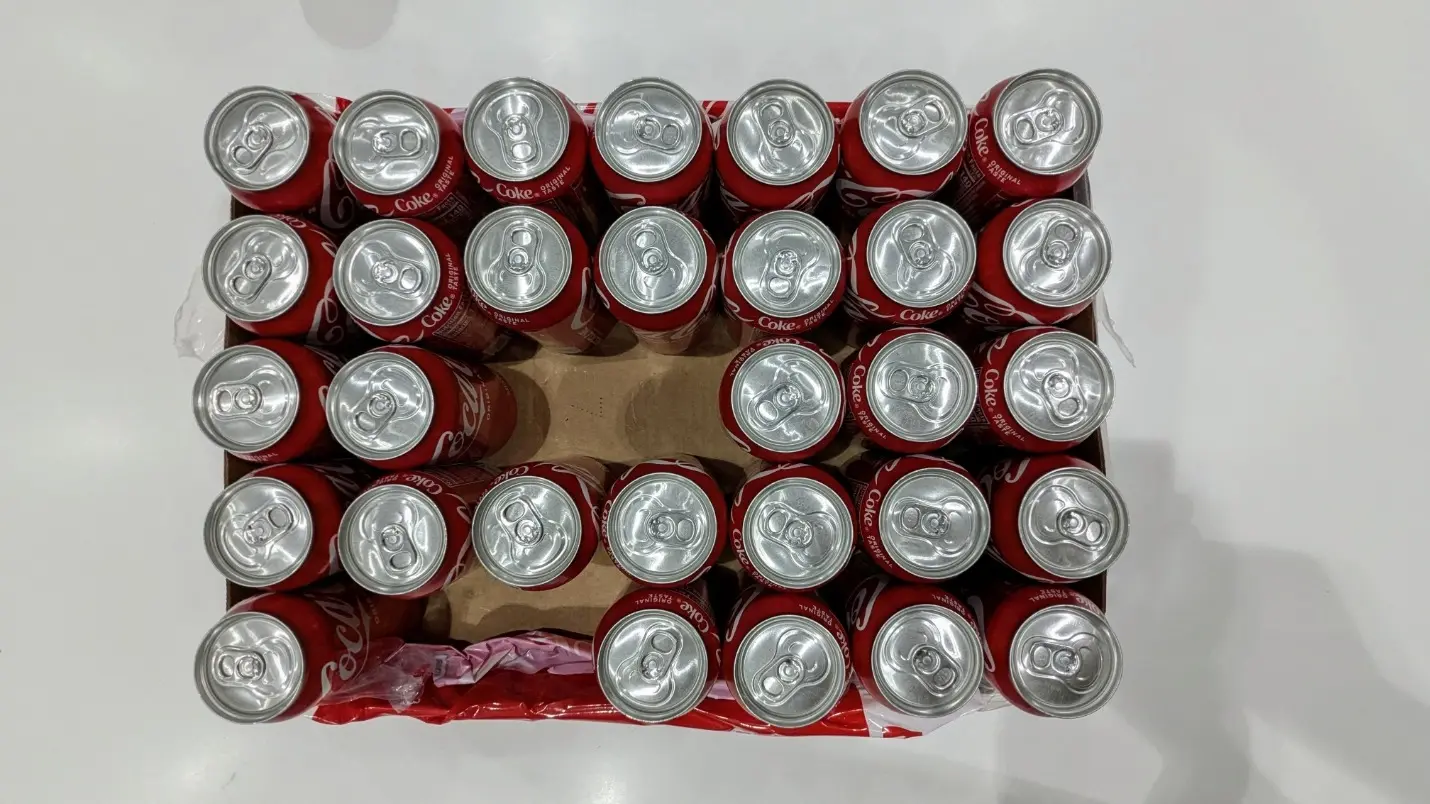

In [4]:
from vision_agent.tools import load_image
import PIL.Image

input_image_url = "./soda_cans.jpg"

img_np = load_image(input_image_url)
img_pil = PIL.Image.fromarray(img_np)
image_path = "soda_cans.png"
img_pil.save(image_path)

# Let's see the image
img_pil

### Step 2 - Write a prompt

Now we need to write a prompt that describes the vision task that we want VisionAgent to generate code for.

Below is the prompt we wrote for this task.

In [5]:
user_prompt = """
Write a program that counts soda cans in an image.
The program should output the count, draw bounding boxes around each detected can,
and display the confidence score for each prediction. Additionally, calculate the
inventory percentage based on a maximum capacity of 35 cans. If the inventory is
below 50%, the program should output a status of "Needs Restocking." If the
inventory is above 50%, it should output a status of "Healthy."""

### Code Generation Process

What happens under the hood is that the agent will generate a plan for the code generation task, and then generate code and test case based on the plan. Then the agent will test the generated code with the test case. If the test case fails, the agent will iterate on the code generation process until the test case passes.


> Tip: you may need to tweak the prompt, or even the input image to get the desired result. 


The `generate_code()` method expects a list of dictionary as input messages, similar to the [OpenAI chat completion API](https://platform.openai.com/docs/api-reference/chat/create).

The first message is always the user prompt.


In [6]:

# We just supplied the first message since this is the start of the conversation.
messages = [
    AgentMessage(
        role="user",
        content=user_prompt,
        media=[image_path],
    )
]

response = agent.generate_code(messages)

Step 10: I need to gather more information about the image and understand the problem better. I will start by 
loading the image, asking the VQA model to describe it and count the soda cans, and getting a suggestion on how to 
proceed with the task.

Code to Execute:

============================== Code ==============================

  1                                                                                                                
  2 image = load_image('soda_cans.png')                                                                            
  3 vqa('Can you describe this image? How many soda cans do you see in the image?', [image])                       
  4 suggestion('How can I count the number of soda cans in the image, draw bounding boxes around each detected can,
    display the confidence score for each prediction, and calculate the inventory percentage?', [image])           
  5                                                                                                                

Code Execution Output (34.31s): ----- stdout -----
[vqa output]
The image shows a box containing 24 Coca-Cola soda cans arranged in a grid pattern. The cans are red with silver 
tabs and are neatly organized in four rows of six cans each. The box appears to be open, revealing the cans inside.
The background is plain white, which helps highlight the red color of the cans.
[end of vqa output]

<plan>
To achieve your goals with the given image, we can utilize the `object_detection_and_counting` tool from the 
available options. This is because it satisfies all your requirements: detecting and counting the soda cans, 
drawing bounding boxes, displaying confidence scores, and calculating inventory percentages. Here’s how to proceed:

### Detect and Count Soda Cans
Use the object detection and counting tool with the text prompt `"soda can"`:

```python
# Load image
image_resized = load_image("path/to/image.jpg")  # Assuming this is your method to load the resized image

# Use the object detection and counting tool
detections = get_tool_for_task('object_detection_and_counting', "soda can", image_resized)
```

### Drawing Bounding Boxes and Displaying Confidence Scores
Once soda cans are detected, iterate over the results to draw bounding boxes and display confidence scores:

```python
import numpy as np
from PIL import Image, ImageDraw

# Convert image to PIL format
img_pil = Image.fromarray(np.uint8(image_resized * 255)).convert('RGB')
draw = ImageDraw.Draw(img_pil)

# Constants for drawing options (optional, adjust as needed)
bbox_color = "red"
bbox_thickness = 2 
font = ImageFont.load_default()  # Can specify font size or load a custom TTF file

# Draw bounding boxes and confidence scores in the image
for det in detections:
    label = det['label']
    bbox = det['bbox']  # Normalized coords
    conf = det['score']

    width, height = img_pil.size  # PIL image dimensions
    bbox_unnorm = [
        bbox[0] * width, bbox[1] * height, 
        bbox[2] * width, bbox[3] * height
    ]

    # Draw bbox
    draw.rectangle(bbox_unnorm, outline=bbox_color, width=bbox_thickness)

    # Add confidence text near the bounding box. Optional formatting of the text delegated to the implementation  
    text = f'{label}: {conf:.2f}'
    draw.text((bbox_unnorm[0], bbox_unnorm[1]), text, fill='black', font=font)

# Save the new image with boxes and scores shown. Output path should be adjusted
output_path = 'output_image.jpg'
img_pil.save(output_path)
print(f"Output image saved to {output_path}")
```

### Calculate Inventory Percentage
To calculate the total (expected) number of cans and determine the inventory percentage:

```python
# Total expected number of cans. Assumes an orderly grid arrangement without gaps but accommodates some variability
total_cans_patches = 5 * 5  # Assuming rows/columns based on typical packaging or grid visible

actual_count = len(detections)
inventory_percentage = (actual_count / total_cans_patches) * 100
print(f"Inventory Percentage: {inventory_percentage:.2f}%")
```

**Note:**  
The evaluation assumes the total number of soda cans should be 25 in this case (arranged in a 4x6 grid excluding 
the empty spaces), based on visual inspection经纪人发现. Adjust the total count variable (`5 * 5`) accordingly if 
necessary. Inventory percentage calculations depend heavily on obtaining this correct total number first.
  
This suggested implementation simplifies the process while ensuring customization for specific image requirements. 
Feel free to tailor more complex approaches, e.g., nesting some detection logic within loops if finer grain, 
rotation handling, or other pre-processing enhancements are necessary.
</plan>

----- stderr -----

Step 9: Based on the VQA output and the suggestion, I have a clear understanding of the image content and the steps
needed to achieve the user's request. The next step is to find a suitable tool for object detection and counting of
soda cans. I will use `get_tool_for_task` to find the appropriate tool for this task.

Code to Execute:

============================== Code ==============================

  1                                                                                                                
  2 get_tool_for_task('Count the number of soda cans in the image', [image])                                       

Code Execution Output (112.33s): ----- stdout -----
[get_tool_for_task output]
Given the user request to count the number of soda cans in an image, the most suitable tool from the available 
options is 'countgd_object_detection'. This tool is particularly designed for detecting and counting multiple 
instances of an object, making it highly relevant for the task at hand. Tools like 'qwen25_vl_video_vqa', 
'qwen25_vl_images_vqa', and 'document_qa' are more suited for answering questions related to videos, images, or 
documents but not specifically for object detection and counting. The 'glee_object_detection' could also count the 
objects but since 'countgd_object_detection' is better specialized in counting scenarios this would be the primary 
choice. Considering that our image has a noticeable amount of soda cans tightly arranged, the 
'countgd_object_detection' should perform accurately. Thus, the prompt 'soda can' was used with the 
'countgd_object_detection' method.

Tool Documentation:
countgd_object_detection(prompt: str, image: numpy.ndarray, box_threshold: float = 0.23) -> List[Dict[str, Any]]:
'countgd_object_detection' is a tool that can detect multiple instances of an
    object given a text prompt. It is particularly useful when trying to detect and
    count a large number of objects. You can optionally separate object names in the
    prompt with commas. It returns a list of bounding boxes with normalized
    coordinates, label names and associated confidence scores.

    Parameters:
        prompt (str): The object that needs to be counted.
        image (np.ndarray): The image that contains multiple instances of the object.
        box_threshold (float, optional): The threshold for detection. Defaults
            to 0.23.

    Returns:
        List[Dict[str, Any]]: A list of dictionaries containing the score, label, and
            bounding box of the detected objects with normalized coordinates between 0
            and 1 (xmin, ymin, xmax, ymax). xmin and ymin are the coordinates of the
            top-left and xmax and ymax are the coordinates of the bottom-right of the
            bounding box.

    Example
    -------
        >>> countgd_object_detection("flower", image)
        [
            {'score': 0.49, 'label': 'flower', 'bbox': [0.1, 0.11, 0.35, 0.4]},
            {'score': 0.68, 'label': 'flower', 'bbox': [0.2, 0.21, 0.45, 0.5},
            {'score': 0.78, 'label': 'flower', 'bbox': [0.3, 0.35, 0.48, 0.52},
            {'score': 0.98, 'label': 'flower', 'bbox': [0.44, 0.24, 0.49, 0.58},
        ]
[end of get_tool_for_task output]


----- stderr -----

Step 8: With the chosen tool `countgd_object_detection`, I can now detect and count the soda cans in the image. 
After obtaining the detections, I will draw bounding boxes around each detected can and display the confidence 
score for each prediction. Then, I'll calculate the inventory percentage based on a maximum capacity of 35 cans and
determine whether the inventory needs restocking or is healthy. Let's proceed with the detection and subsequent 
steps.

Code to Execute:

============================== Code ==============================

   1                                                                                                               
   2 # Detect soda cans in the image                                                                               
   3 detections = countgd_object_detection("soda can", image)                                                      
   4                                                                                                               
   5 # Draw bounding boxes and display confidence scores                                                           
   6 import numpy as np                                                                                            
   7 from PIL import Image, ImageDraw, ImageFont                                                                   
   8                                                                                                               
   9 # Convert image to PIL format                                                                                 
  10 img_pil = Image.fromarray(np.uint8(image * 255)).convert('RGB')                                               
  11 draw = ImageDraw.Draw(img_pil)                                                                                
  12                                                                                                               
  13 # Constants for drawing options                                                                               
  14 bbox_color = "red"                                                                                            
  15 bbox_thickness = 2                                                                                            
  16 font = ImageFont.load_default()                                                                               
  17                                                                                                               
  18 # Draw bounding boxes and confidence scores in the image                                                      
  19 for det in detections:                                                                                        
  20     label = det['label']                                                                                      
  21     bbox = det['bbox']  # Normalized coords                                                                   
  22     conf = det['score']                                                                                       
  23                                                                                                               
  24     width, height = img_pil.size  # PIL image dimensions                                                      
  25     bbox_unnorm = [                                                                                           
  26         bbox[0] * width, bbox[1] * height,                                                                    
  27         bbox[2] * width, bbox[3] * height                                                                     
  28     ]                                                                                                         
  29                                                                                                               
  30     # Draw bbox                                                                                               
  31     draw.rectangle(bbox_unnorm, outline=bbox_color, width=bbox_thickness)                                     
  32                                                                                                               
  33     # Add confidence text near the bounding box                                                               
  34     text = f'{label}: {conf:.2f}'                                                                             
  35 [38;2;221;221;221;48;2;40;40;40

Code Execution Output (30.75s): ----- stdout -----
Output image saved to output_image.jpg
Inventory Percentage: 88.57%
Status: Healthy
Number of detected soda cans: 31

----- stderr -----

Step 7: None

Finalizing Plan: This plan successfully detects and counts the soda cans in the image, draws bounding boxes around 
each detected can, displays the confidence score for each prediction, calculates the inventory percentage based on 
a maximum capacity of 35 cans, and determines the inventory status. The program detected 31 soda cans, resulting in
an inventory percentage of 88.57% and a status of "Healthy". The output image with bounding boxes and confidence 
scores is saved to 'output_image.jpg'.

Final Plan: The plan involves using the `countgd_object_detection` tool to detect and count the number of soda cans
in an image. Afterwards, it draws bounding boxes around each detected soda can, displays the confidence score for 
each prediction, calculates the inventory percentage based on a maximum capacity of 35 cans, and determines whether
the inventory needs restocking or is healthy. Finally, it saves the output image with bounding boxes and confidence
scores to 'output_image.jpg'. The expected answer is that 31 soda cans were detected, resulting in an inventory 
percentage of 88.57% and a status of 'Healthy'.

                                                     Plan                                                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Instructions                                                                                                ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Use the `countgd_object_detection` tool to detect and count the soda cans in the image.                     │
│ ---------------------------------------------------------------------------------------                     │
│ Overlay bounding boxes and confidence scores on the original image using the `overlay_bounding_boxes` tool. │
│ ----------------------------------------------------------------------------------------------------------- │
│ Save the output image with the bounding boxes and confidence scores using the `save_image` tool.            │
│ ------------------------------------------------------------------------------------------------            │
│ Calculate the inventory percentage and determine the inventory status.                                      │
│ ----------------------------------------------------------------------                                      │
│ Return the count of detected soda cans, inventory percentage, and inventory status.                         │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

Plan Code

============================== Code ==============================

   1                                                                                                               
   2 def analyze_soda_cans(image_path, max_capacity=35, output_image_path="output_image.jpg"):                     
   3     """                                                                                                       
   4     Analyze an image to count soda cans, draw bounding boxes with confidence scores,                          
   5     calculate the inventory percentage, and determine the stock status.                                       
   6                                                                                                               
   7     Parameters:                                                                                               
   8         image_path (str): Path to the input image containing soda cans.                                       
   9         max_capacity (int, optional): The maximum capacity of the inventory. Default is 35.                   
  10         output_image_path (str, optional): Path where the output image will be saved. Default is              
     'output_image.jpg'.                                                                                           
  11                                                                                                               
  12     Returns:                                                                                                  
  13         tuple: Number of detected soda cans, inventory percentage, and inventory status.                      
  14     """                                                                                                       
  15     from vision_agent.tools import load_image, overlay_bounding_boxes, save_image, countgd_object_detection   
  16                                                                                                               
  17     # Load the image using the 'load_image' tool                                                              
  18     image = load_image(image_path)                                                                            
  19                                                                                                               
  20     # Detect soda cans using the 'countgd_object_detection' tool                                              
  21     detections = countgd_object_detection("soda can", image)                                                  
  22                                                                                                               
  23     # Overlay bounding boxes and confidence scores onto the image                                             
  24     image_with_boxes = overlay_bounding_boxes(image, detections)                                              
  25                                                                                                               
  26     # Save the image with bounding boxes using the 'save_image' tool                                          
  27     save_image(image_with_boxes, output_image_path)                                                           
  28                                                                                                               
  29     # Calculate the inventory percentage                                                                      
  30     actual_count = len(detections)                                                                            
  31     inventory_percentage = (actual_count / max_capacity) * 100                                                
  32                                                                                                               
  33     # Determine the inventory status                                                                          
  34     status = "Needs Restocking" if inventory_percen

Code:

============================== Code ==============================

   1                                                                                                               
   2 def analyze_soda_cans(image_path, max_capacity=35, output_image_path="output_image.jpg"):                     
   3     """                                                                                                       
   4     Analyze an image to count soda cans, draw bounding boxes with confidence scores,                          
   5     calculate the inventory percentage, and determine the stock status.                                       
   6                                                                                                               
   7     Parameters:                                                                                               
   8         image_path (str): Path to the input image containing soda cans.                                       
   9         max_capacity (int, optional): The maximum capacity of the inventory. Default is 35.                   
  10         output_image_path (str, optional): Path where the output image will be saved. Default is              
     'output_image.jpg'.                                                                                           
  11                                                                                                               
  12     Returns:                                                                                                  
  13         tuple: Number of detected soda cans, inventory percentage, and inventory status.                      
  14     """                                                                                                       
  15     from vision_agent.tools import load_image, overlay_bounding_boxes, save_image, countgd_object_detection   
  16                                                                                                               
  17     # Load the image using the 'load_image' tool                                                              
  18     image = load_image(image_path)                                                                            
  19                                                                                                               
  20     # Detect soda cans using the 'countgd_object_detection' tool                                              
  21     detections = countgd_object_detection("soda can", image)                                                  
  22                                                                                                               
  23     # Overlay bounding boxes and confidence scores onto the image                                             
  24     image_with_boxes = overlay_bounding_boxes(image, detections)                                              
  25                                                                                                               
  26     # Save the image with bounding boxes using the 'save_image' tool                                          
  27     save_image(image_with_boxes, output_image_path)                                                           
  28                                                                                                               
  29     # Calculate the inventory percentage                                                                      
  30     actual_count = len(detections)                                                                            
  31     inventory_percentage = (actual_count / max_capacity) * 100                                                
  32                                                                                                               
  33     # Determine the inventory status                                                                          
  34     status = "Needs Restocking" if inventory_percen

Test:

============================== Code ==============================

   1                                                                                                               
   2 def test_analyze_soda_cans():                                                                                 
   3     """                                                                                                       
   4     Test the analyze_soda_cans function with the provided 'soda_cans.png' image.                              
   5     This test checks the fundamental functionality under normal conditions.                                   
   6     It ensures that the function returns a tuple with the correct format and that the output image is not     
     empty.                                                                                                        
   7     """                                                                                                       
   8                                                                                                               
   9     # Define the path to the input image and the expected output image path                                   
  10     input_image_path = 'soda_cans.png'                                                                        
  11     output_image_path = 'output_image.jpg'                                                                    
  12                                                                                                               
  13     # Call the function to analyze the soda cans in the image                                                 
  14     result = analyze_soda_cans(input_image_path, output_image_path=output_image_path)                         
  15                                                                                                               
  16     # Check if the result is not empty and has the expected format (tuple with three elements)                
  17     if not result or len(result) != 3:                                                                        
  18         print("Test failed: The function did not return a tuple with three elements.")                        
  19         return                                                                                                
  20                                                                                                               
  21     # Unpack the result tuple                                                                                 
  22     actual_count, inventory_percentage, status = result                                                       
  23                                                                                                               
  24     # Print the output of the function                                                                        
  25     print(f"Detected Soda Cans: {actual_count}")                                                              
  26     print(f"Inventory Percentage: {inventory_percentage}%")                                                   
  27     print(f"Inventory Status: {status}")                                                                      
  28                                                                                                               
  29     # Check if the output image exists and is not empty                                                       
  30     from os.path import getsize                                                                               
  31     if not getsize(output_image_path):                                                                        
  32         print("Test failed: The output image is empty.")                                                      
  33         return                                                                                                
  34                                                    

Code execution result: ----- stdout -----
Detected Soda Cans: 31
Inventory Percentage: 88.57%
Inventory Status: Healthy

----- stderr -----

----- Final output -----
(31, 88.57, 'Healthy')

### Step 3 - Inspect the result

The output of the `generate_code` method is a [CodeContext](https://github.com/landing-ai/vision-agent/blob/main/vision_agent/agent/agent_utils.py#L33-L37) object, which contains the generated code, a test case, a success flag, and the result of the test case.


```python
class CodeContext(BaseModel):
    code: str
    test: str
    success: bool
    test_result: Execution
```

Let's check the generated code.

In [7]:
from rich.console import Console
from rich.syntax import Syntax

def print_code(code: str) -> None:
    Console().print(
        Syntax(
            code,
            "python",
            theme="gruvbox-dark",
            line_numbers=False,
            word_wrap=True,
        )
    )

print_code(response.code)

import os                                                                                                          
import numpy as np                                                                                                 
from vision_agent.tools import *                                                                                   
from vision_agent.tools.planner_tools import judge_od_results                                                      
from typing import *                                                                                               
from pillow_heif import register_heif_opener                                                                       
register_heif_opener()                                                                                             
import vision_agent as va                                                                                          
from vision_agent.tools import register_tool                                                                       
                                                                                                                   
def analyze_soda_cans(image_path, max_capacity=35, output_image_path="output_image.jpg"):                          
    """                                                                                                            
    Analyze an image to count soda cans, draw bounding boxes with confidence scores,                               
    calculate the inventory percentage, and determine the stock status.                                            
                                                                                                                   
    Parameters:                                                                                                    
        image_path (str): Path to the input image containing soda cans.                                            
        max_capacity (int, optional): The maximum capacity of the inventory. Default is 35.                        
        output_image_path (str, optional): Path where the output image will be saved. Default is                   
'output_image.jpg'.                                                                                                
                                                                                                                   
    Returns:                                                                                                       
        tuple: Number of detected soda cans, inventory percentage, and inventory status.                           
    """                                                                                                            
    from vision_agent.tools import load_image, overlay_bounding_boxes, save_image, countgd_object_detection        
                                                                                                                   
    # Load the image using the 'load_image' tool                                                                   
    image = load_image(image_path)                                                                                 
                                                                                                                   
    # Detect soda cans using the 'countgd_object_detection' tool                                                   
    detections = countgd_object_detection("soda can", image)                                                       
                                                                                                                   
    # Overlay bounding boxes and confidence scores onto the image                                                  
    image_with_boxes = overlay_bounding_boxes(image, detections)                                                   
                                                        

## Test Generated Code

The code above looks correct. Let's test it to see if it works.

Let's first copy the code to a new cell below.

In [8]:
import os                                                                                                          
import numpy as np                                                                                                 
from vision_agent.tools import *                                                                                   
from vision_agent.tools.planner_tools import judge_od_results                                                      
from typing import *                                                                                               
from pillow_heif import register_heif_opener                                                                       
register_heif_opener()                                                                                             
import vision_agent as va                                                                                          
from vision_agent.tools import register_tool                                                                       
                                                                                                                   
from vision_agent.tools import load_image, countgd_object_detection, overlay_bounding_boxes, save_image            
                                                                                                                   
def count_soda_cans_and_status(image_path: str):                                                                   
    """                                                                                                            
    Detects soda cans in the given image, draws bounding boxes                                                     
    around each detected can with confidence scores, calculates                                                    
    inventory percentage based on a max capacity of 35 cans,                                                       
    determines the inventory status ('Healthy' or 'Needs Restocking'),                                             
    saves the annotated image, and returns the final results.                                                      
                                                                                                                   
    Parameters                                                                                                     
    ----------                                                                                                     
    image_path: str                                                                                                
        The path or URL to an image with soda cans.                                                                
                                                                                                                   
    Returns                                                                                                        
    -------                                                                                                        
    dict                                                                                                           
        {                                                                                                          
            "count": int - total number of cans detected,                                                          
            "percentage": float - inventory percentage,                                                            
            "status": str - 'Healthy' or 'Needs Restocking',                                                       
            "annotated_image_path": str - path to the saved annotated image                                        
        }                                                                                                          
    """                                                                                                            
    # 1. Load the image                                                                                            
    image = load_image(image_path)                                                                                 
                                                                                                                   
    # 2. Detect soda cans                                                                                          
    detections = countgd_object_detection("soda can, beverage can", image)                                         
                                                                                                                   
    # 3. Overlay bounding boxes with confidence scores in label                                                    
    for det in detections:                                                                                         
        det['label'] = f"{det.get('label', 'can')} {det['score']:.2f}"                                             
    annotated_image = overlay_bounding_boxes(image, detections)                                                    
                                                                                                                   
    # 4. Count the detected cans                                                                                   
    count_of_cans = len(detections)                                                                                
                                                                                                                   
    # 5. Compute the inventory percentage                                                                          
    max_capacity = 35                                                                                              
    percentage = (count_of_cans / max_capacity) * 100.0                                                            
                                                                                                                   
    # 6. Determine the status                                                                                      
    status = "Healthy" if percentage >= 50 else "Needs Restocking"                                                 
                                                                                                                   
    # 7. Save the annotated image                                                                                  
    output_path = "annotated_soda_cans.png"                                                                        
    save_image(annotated_image, output_path)                                                                       
                                                                                                                   
    # 8. Return final information                                                                                  
    return {                                                                                                       
        "count": count_of_cans,                                                                                    
        "percentage": percentage,                                                                                  
        "status": status,                                                                                          
        "annotated_image_path": output_path                                                                        
} 

Write a test case for the code above.

| Tip: to get started with a simple test case, you can reference the `test` field from the response object, i.e. `response.test`.

Number of cans detected: 31
Inventory percentage: 88.57142857142857%
Status: Healthy


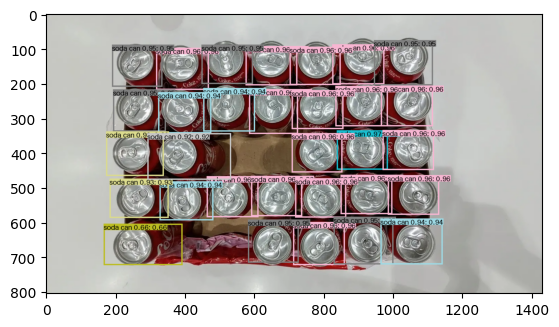

In [9]:
from vision_agent.tools import load_image
import matplotlib.pyplot as plt

                                                                                        
image = load_image(image_path)
inventory_data = count_soda_cans_and_status(image)                                                  
                                                                                                                 
print(f"Number of cans detected: {inventory_data['count']}")                                                
print(f"Inventory percentage: {inventory_data['percentage']}%")                                        
print(f"Status: {inventory_data['status']}")
viz = load_image(inventory_data['annotated_image_path'])
plt.imshow(viz)
plt.show()

The result looks good. Let's try another image.

Number of cans detected: 24
Inventory percentage: 68.57142857142857%
Status: Healthy


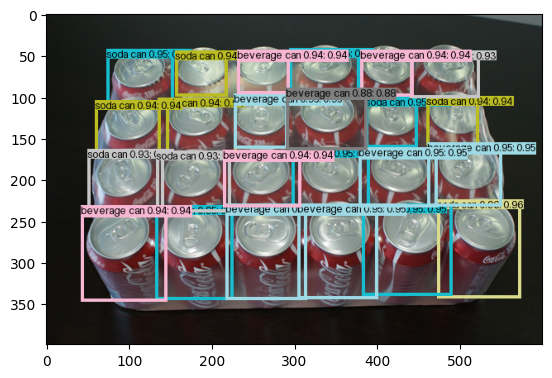

In [25]:
test_image_url = "https://drive.usercontent.google.com/u/0/uc?id=12wGLC-P0CLxcxJLmQ6f7hu5BpbWM8Y9c"

image = load_image(test_image_url)
inventory_data = count_soda_cans_and_status(image)                                                  
                                                                                                                 
print(f"Number of cans detected: {inventory_data['count']}")                                                
print(f"Inventory percentage: {inventory_data['percentage']}%")                                        
print(f"Status: {inventory_data['status']}")

viz = load_image(inventory_data['annotated_image_path'])
plt.imshow(viz)
plt.show()

## Customize the generated code

The Inventory percentage from the above result should be 100% but it's showing 68.6%. This is because the generated code harded coded the maximum capacity of the inventory to 35 cans.

Let's update the generated code to allow passing maximum capacity as a parameter.


In [26]:
import os                                                                                                          
import numpy as np                                                                                                 
from vision_agent.tools import *                                                                                   
from vision_agent.tools.planner_tools import judge_od_results                                                      
from typing import *                                                                                               
from pillow_heif import register_heif_opener                                                                       
register_heif_opener()                                                                                             
import vision_agent as va                                                                                          
from vision_agent.tools import register_tool                                                                       
                                                                                                                   
from vision_agent.tools import load_image, countgd_object_detection, overlay_bounding_boxes, save_image            
                                                                                                                   
def count_soda_cans_and_status(image_path: str, max_capacity: int):                                                                   
    """                                                                                                            
    Detects soda cans in the given image, draws bounding boxes                                                     
    around each detected can with confidence scores, calculates                                                    
    inventory percentage based on a max capacity of 35 cans,                                                       
    determines the inventory status ('Healthy' or 'Needs Restocking'),                                             
    saves the annotated image, and returns the final results.                                                      
                                                                                                                   
    Parameters                                                                                                     
    ----------                                                                                                     
    image_path: str                                                                                                
        The path or URL to an image with soda cans.                                                                
                                                                                                                   
    Returns                                                                                                        
    -------                                                                                                        
    dict                                                                                                           
        {                                                                                                          
            "count": int - total number of cans detected,                                                          
            "percentage": float - inventory percentage,                                                            
            "status": str - 'Healthy' or 'Needs Restocking',                                                       
            "annotated_image_path": str - path to the saved annotated image                                        
        }                                                                                                          
    """                                                                                                            
    # 1. Load the image                                                                                            
    image = load_image(image_path)                                                                                 
                                                                                                                   
    # 2. Detect soda cans                                                                                          
    detections = countgd_object_detection("soda can, beverage can", image)                                         
                                                                                                                   
    # 3. Overlay bounding boxes with confidence scores in label                                                    
    for det in detections:                                                                                         
        det['label'] = f"{det.get('label', 'can')} {det['score']:.2f}"                                             
    annotated_image = overlay_bounding_boxes(image, detections)                                                    
                                                                                                                   
    # 4. Count the detected cans                                                                                   
    count_of_cans = len(detections)                                                                                
                                                                                                                   
    # 5. Compute the inventory percentage                                                                                                                                                                       
    percentage = (count_of_cans / max_capacity) * 100.0                                                            
                                                                                                                   
    # 6. Determine the status                                                                                      
    status = "Healthy" if percentage >= 50 else "Needs Restocking"                                                 
                                                                                                                   
    # 7. Save the annotated image                                                                                  
    output_path = "annotated_soda_cans.png"                                                                        
    save_image(annotated_image, output_path)                                                                       
                                                                                                                   
    # 8. Return final information                                                                                  
    return {                                                                                                       
        "count": count_of_cans,                                                                                    
        "percentage": percentage,                                                                                  
        "status": status,                                                                                          
        "annotated_image_path": output_path                                                                        
} 

In [29]:
test_image_url = "https://drive.usercontent.google.com/u/0/uc?id=12wGLC-P0CLxcxJLmQ6f7hu5BpbWM8Y9c"

test_image = load_image(test_image_url)
inventory_data = count_soda_cans_and_status(test_image, max_capacity=24)

print(f"Number of cans detected: {inventory_data['count']}")
print(f"Inventory percentage: {inventory_data['percentage']}%")
print(f"Status: {inventory_data['status']}")

Number of cans detected: 24
Inventory percentage: 100.0%
Status: Healthy


It looks like the code works as expected.

## Conclusion

In this notebook, we demonstrated how to use VisionAgent to generate code that counts cans in an image. We also showed how to test the generated code to ensure it works as expected.

## Next Steps

- Try the VisionAgent web app at [va.landing.ai](https://va.landing.ai)
- Learn more about the VisionAgent ecosystem in [this blog](https://landing.ai/blog/introducing-visionagent-your-visual-ai-pilot)
- Check out the open source repo at [github.com/landing-ai/vision-agent](https://github.com/landing-ai/vision-agent)